In [24]:
# Import live code changes in
%load_ext autoreload
%autoreload 

from pathlib import Path
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sovereign.flood import build_basin_curves, BasinLossCurve, risk_data_future_shift, run_simulation, extract_sectoral_losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set filepaths and provide data info

In [25]:
root = Path.cwd().parent # find project root
risk_basin_path = os.path.join(root, 'outputs', 'flood', 'risk', 'basins', 'risk_basins.csv')
copula_path = os.path.join(root, 'outputs', 'flood', 'dependence', 'copulas')
risk_data = pd.read_csv(risk_basin_path)
future_rp_shifts = pd.read_csv(os.path.join(root, 'outputs', 'flood', 'future', 'basin_rp_shifts.csv'))
# Drop first "unnamed column"
risk_data = risk_data.iloc[:, 1:]
# Add AEP column
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
risk_data.reset_index(drop=True, inplace=True)

#### Run a simulation

In [75]:
# USER CONFIG
adaptation_aep = 0.01 # 100-year flood protection
n_years = 10000 # number of years to simulate
# Future parameters
future_hydro = 'jules-w2'
future_epoch = 2070

In [76]:
# Adjust future risk data
# future_risk_data = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, future_scenario, future_epoch, future_stat, degrade_protection=True)
future_ssp126_risk_data_q10 = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp126', future_epoch, 'q05', degrade_protection=True)
future_ssp126_risk_data_mean = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp126', future_epoch, 'mean', degrade_protection=True)
future_ssp126_risk_data_q90 = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp126', future_epoch, 'q95', degrade_protection=True)
future_ssp370_risk_data_q10 = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp370', future_epoch, 'q05', degrade_protection=True)
future_ssp370_risk_data_mean = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp370', future_epoch, 'mean', degrade_protection=True)
future_ssp370_risk_data_q90 = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp370', future_epoch, 'q95', degrade_protection=True)
future_ssp585_risk_data_q10 = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp585', future_epoch, 'q05', degrade_protection=True)
future_ssp585_risk_data_mean = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp585', future_epoch, 'mean', degrade_protection=True)
future_ssp585_risk_data_q90 = risk_data_future_shift(risk_data, future_rp_shifts, future_hydro, 'ssp585', future_epoch, 'q95', degrade_protection=True)

In [77]:
# Build basin loss probability curves
baseline_curves: dict[int, BasinLossCurve] = build_basin_curves(risk_data)
future_ssp126_q10_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp126_risk_data_q10)
future_ssp126_mean_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp126_risk_data_mean)
future_ssp126_q90_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp126_risk_data_q90)
future_ssp370_q10_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp370_risk_data_q10)
future_ssp370_mean_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp370_risk_data_mean)
future_ssp370_q90_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp370_risk_data_q90)
future_ssp585_q10_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp585_risk_data_q10)
future_ssp585_mean_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp585_risk_data_mean)
future_ssp585_q90_curves: dict[int, BasinLossCurve] = build_basin_curves(future_ssp585_risk_data_q90)

In [78]:
# Prepare simulation
n_years = 10000 # number of years to simulate
adaptation_aep = 0.01 # protection level for adaptation
# Load precomputed copula basin dependence simulations
copula_random_numbers = pd.read_parquet(os.path.join(copula_path, "copula_random_numbers.gzip"))

In [79]:
# Run baseline simulation
baseline_losses, baseline_adapted_losses = run_simulation(baseline_curves, n_years, adaptation_aep, copula_random_numbers)
# Run future simulation
future_ssp126_losses_q10, future_ssp126_adapted_losses_q10 = run_simulation(future_ssp126_q10_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp126_losses_mean, future_ssp126_adapted_losses_mean = run_simulation(future_ssp126_mean_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp126_losses_q90, future_ssp126_adapted_losses_q90 = run_simulation(future_ssp126_q90_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp370_losses_q10, future_ssp370_adapted_losses_q10 = run_simulation(future_ssp370_q10_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp370_losses_mean, future_ssp370_adapted_losses_mean = run_simulation(future_ssp370_mean_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp370_losses_q90, future_ssp370_adapted_losses_q90 = run_simulation(future_ssp370_q90_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp585_losses_q10, future_ssp585_adapted_losses_q10 = run_simulation(future_ssp585_q10_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp585_losses_mean, future_ssp585_adapted_losses_mean = run_simulation(future_ssp585_mean_curves, n_years, adaptation_aep, copula_random_numbers)
future_ssp585_losses_q90, future_ssp585_adapted_losses_q90 = run_simulation(future_ssp585_q90_curves, n_years, adaptation_aep, copula_random_numbers)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:17<00:00, 128.47it/s]


#### Inspect Results

In [84]:
# Extract sectoral losses
baseline_sectoral_loss = extract_sectoral_losses(baseline_losses, n_years)
# future_sectoral_loss = extract_sectoral_losses(future_losses, n_years)
# future_adapted_sectoral_loss = extract_sectoral_losses(future_adapted_losses, n_years)
future_ssp126_sectoral_loss_q10 = extract_sectoral_losses(future_ssp126_losses_q10, n_years)
future_ssp126_sectoral_loss_mean = extract_sectoral_losses(future_ssp126_losses_mean, n_years)
future_ssp126_sectoral_loss_q90 = extract_sectoral_losses(future_ssp126_losses_q90, n_years)
future_ssp370_sectoral_loss_q10 = extract_sectoral_losses(future_ssp370_losses_q10, n_years)
future_ssp370_sectoral_loss_mean = extract_sectoral_losses(future_ssp370_losses_mean, n_years)
future_ssp370_sectoral_loss_q90 = extract_sectoral_losses(future_ssp370_losses_q90, n_years)
future_ssp585_sectoral_loss_q10 = extract_sectoral_losses(future_ssp585_losses_q10, n_years)
future_ssp585_sectoral_loss_mean = extract_sectoral_losses(future_ssp585_losses_mean, n_years)
future_ssp585_sectoral_loss_q90 = extract_sectoral_losses(future_ssp585_losses_q90, n_years)

In [85]:
sector = "CAP_dam"
print(f"{sector} AAL baseline:", baseline_sectoral_loss[sector].mean())
# print(f"{sector} AAL future:", future_sectoral_loss['CAP_dam'].mean())
# print(f"{sector} AAL future (adapted):", future_adapted_sectoral_loss['CAP_dam'].mean())
print(f"{sector} AAL (q10) future (SSP126):", future_ssp126_sectoral_loss_q10[sector].mean())
print(f"{sector} AAL (mean) future (SSP126):", future_ssp126_sectoral_loss_mean[sector].mean())
print(f"{sector} AAL (q90) future (SSP126):", future_ssp126_sectoral_loss_q90[sector].mean())
print(f"{sector} AAL (q10) future (SSP370):", future_ssp370_sectoral_loss_q10[sector].mean())
print(f"{sector} AAL (mean) future (SSP370):", future_ssp370_sectoral_loss_mean[sector].mean())
print(f"{sector} AAL (q90) future (SSP370):", future_ssp370_sectoral_loss_q90[sector].mean())
print(f"{sector} AAL (q10) future (SSP585):", future_ssp585_sectoral_loss_q10[sector].mean())
print(f"{sector} AAL (mean) future (SSP585):", future_ssp585_sectoral_loss_mean[sector].mean())
print(f"{sector} AAL (q90) future (SSP585):", future_ssp585_sectoral_loss_q90[sector].mean())

CAP_dam AAL baseline: 12026444771.237133
CAP_dam AAL (q10) future (SSP126): 11350238057.569408
CAP_dam AAL (mean) future (SSP126): 14264435481.663141
CAP_dam AAL (q90) future (SSP126): 21033783998.622623
CAP_dam AAL (q10) future (SSP370): 9081403560.46749
CAP_dam AAL (mean) future (SSP370): 13440821244.233152
CAP_dam AAL (q90) future (SSP370): 25863869027.33582
CAP_dam AAL (q10) future (SSP585): 11287856742.23366
CAP_dam AAL (mean) future (SSP585): 16301556305.984673
CAP_dam AAL (q90) future (SSP585): 29968306749.033325


In [86]:
# Extract extreme values
sector = "CAP_dam"
quantile = 0.99
baseline_loss = baseline_sectoral_loss[sector].quantile(quantile)
future_ssp126_loss_q10 = future_ssp126_sectoral_loss_q10[sector].quantile(quantile)
future_ssp126_loss_mean = future_ssp126_sectoral_loss_mean[sector].quantile(quantile)
future_ssp126_loss_q90 = future_ssp126_sectoral_loss_q90[sector].quantile(quantile)
future_ssp370_loss_q10 = future_ssp370_sectoral_loss_q10[sector].quantile(quantile)
future_ssp370_loss_mean = future_ssp370_sectoral_loss_mean[sector].quantile(quantile)
future_ssp370_loss_q90 = future_ssp370_sectoral_loss_q90[sector].quantile(quantile)
future_ssp585_loss_q10 = future_ssp585_sectoral_loss_q10[sector].quantile(quantile)
future_ssp585_loss_mean = future_ssp585_sectoral_loss_mean[sector].quantile(quantile)
future_ssp585_loss_q90 = future_ssp585_sectoral_loss_q90[sector].quantile(quantile)
# future_loss = future_sectoral_loss[sector].quantile(quantile)
# future_adapted_loss = future_adapted_sectoral_loss[sector].quantile(quantile)
print(f'Baseline p:{quantile} loss: {baseline_loss}')
print(f'Future (q10) (SSP126) p:{quantile} loss: {future_ssp126_loss_q10}')
print(f'Future (mean) (SSP126) p:{quantile} loss: {future_ssp126_loss_mean}')
print(f'Future (q90) (SSP126) p:{quantile} loss: {future_ssp126_loss_q90}')
print(f'Future (q10) (SSP370) p:{quantile} loss: {future_ssp370_loss_q10}')
print(f'Future (mean) (SSP370) p:{quantile} loss: {future_ssp370_loss_mean}')
print(f'Future (q90) (SSP370) p:{quantile} loss: {future_ssp370_loss_q90}')
print(f'Future (q10) (SSP585) p:{quantile} loss: {future_ssp585_loss_q10}')
print(f'Future (mean) (SSP585) p:{quantile} loss: {future_ssp585_loss_mean}')
print(f'Future (q90) (SSP585) p:{quantile} loss: {future_ssp585_loss_q90}')
# print(f'Future p:{quantile} loss: {future_loss}')
# print(f'Future (Adapted) p:{quantile} loss: {future_adapted_loss}')

Baseline p:0.99 loss: 186833533224.07184
Future (q10) (SSP126) p:0.99 loss: 181083665596.2195
Future (mean) (SSP126) p:0.99 loss: 206808719088.79477
Future (q90) (SSP126) p:0.99 loss: 245426593853.05856
Future (q10) (SSP370) p:0.99 loss: 161331522059.61423
Future (mean) (SSP370) p:0.99 loss: 199901079046.5472
Future (q90) (SSP370) p:0.99 loss: 262681209770.25797
Future (q10) (SSP585) p:0.99 loss: 175156651017.938
Future (mean) (SSP585) p:0.99 loss: 218803563649.6947
Future (q90) (SSP585) p:0.99 loss: 269936949134.49515


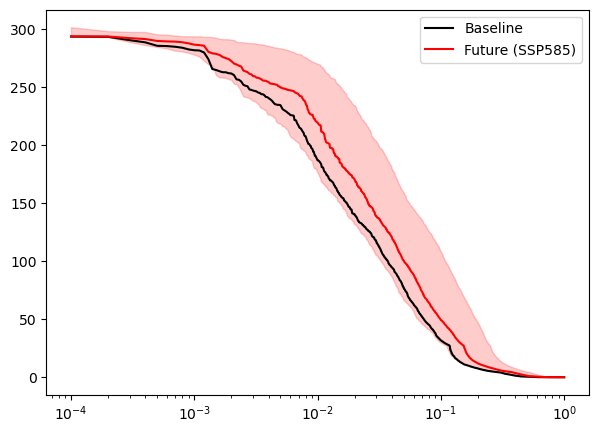

In [89]:
# E-P plot
sector = "CAP_dam"
baseline_losses_sorted = np.sort(baseline_sectoral_loss[sector])[::-1] / 1e9
future_ssp126_losses_sorted_q10 = np.sort(future_ssp126_sectoral_loss_q10[sector])[::-1] / 1e9
future_ssp126_losses_sorted_mean = np.sort(future_ssp126_sectoral_loss_mean[sector])[::-1] / 1e9
future_ssp126_losses_sorted_q90 = np.sort(future_ssp126_sectoral_loss_q90[sector])[::-1] / 1e9
future_ssp370_losses_sorted_q10 = np.sort(future_ssp370_sectoral_loss_q10[sector])[::-1] / 1e9
future_ssp370_losses_sorted_mean = np.sort(future_ssp370_sectoral_loss_mean[sector])[::-1] / 1e9
future_ssp370_losses_sorted_q90 = np.sort(future_ssp370_sectoral_loss_q90[sector])[::-1] / 1e9
future_ssp585_losses_sorted_q10 = np.sort(future_ssp585_sectoral_loss_q10[sector])[::-1] / 1e9
future_ssp585_losses_sorted_mean = np.sort(future_ssp585_sectoral_loss_mean[sector])[::-1] / 1e9
future_ssp585_losses_sorted_q90 = np.sort(future_ssp585_sectoral_loss_q90[sector])[::-1] / 1e9
# future_losses_sorted = np.sort(future_sectoral_loss[sector])[::-1] / 1e9
# future_adapted_losses_sorted = np.sort(future_adapted_sectoral_loss[sector])[::-1] / 1e9
N = len(baseline_sectoral_loss[sector])
exceedance_prob = np.arange(1, N+1) / (N + 1)
plt.figure(figsize=(7,5))
plt.plot(exceedance_prob, baseline_losses_sorted, label='Baseline', color='k')
# plt.fill_between(exceedance_prob, future_ssp126_losses_sorted_q10, future_ssp126_losses_sorted_q90, alpha=0.2, color='green')
# plt.plot(exceedance_prob, future_ssp126_losses_sorted_mean, label='Future (SSP126)', color='green')
# plt.fill_between(exceedance_prob, future_ssp370_losses_sorted_q10, future_ssp370_losses_sorted_q90, alpha=0.2, color='orange')
# plt.plot(exceedance_prob, future_ssp370_losses_sorted_mean, label='Future (SSP370)', color='orange')
plt.fill_between(exceedance_prob, future_ssp585_losses_sorted_q10, future_ssp585_losses_sorted_q90, alpha=0.2, color='red')
plt.plot(exceedance_prob, future_ssp585_losses_sorted_mean, label='Future (SSP585)', color='red')
# plt.plot(exceedance_prob, future_losses_sorted, label='Future')
# plt.plot(exceedance_prob, future_adapted_losses_sorted, label='Future (Adapted)')
plt.legend()
plt.xscale("log")   # optional but standard in catastrophe modelling
plt.yscale("linear")

In [244]:
# def make_loss_probability_curve(losses: np.ndarray) -> pd.DataFrame:
#     """
#     Take an array of annual losses (one per simulation year)
#     and return a DataFrame with sorted losses and plotting-position AEP / RP.
#     """
#     losses = np.asarray(losses, dtype=float)
#     n = len(losses)

#     # Sort descending (largest loss = rarest event)
#     sorted_losses = np.sort(losses)[::-1]

#     # Plotting-position AEP (Weibull): rank / (n + 1)
#     ranks = np.arange(1, n + 1)
#     aep = ranks / (n + 1.0)
#     rp = 1.0 / aep

#     return pd.DataFrame({
#         "loss": sorted_losses,
#         "AEP": aep,
#         "RP": rp,
#     })

In [11]:
# baseline_total = sum(baseline_losses[s] for s in cap_sectors)
# future_total   = sum(future_losses[s]   for s in cap_sectors)

In [12]:
# baseline_curve = make_loss_probability_curve(baseline_total)
# future_curve   = make_loss_probability_curve(future_total)

# fig, ax = plt.subplots(figsize=(6, 4))

# ax.plot(baseline_curve["RP"], baseline_curve["loss"], label="Baseline")
# ax.plot(future_curve["RP"],   future_curve["loss"],   label="Future", linestyle="--")

# # ax.set_xscale("log")
# ax.set_xlabel("Return period (years)")
# ax.set_ylabel("Loss")
# ax.set_title("Loss–probability curve (baseline vs future)")
# ax.legend()
# ax.grid(True, which="both", alpha=0.3)

# plt.tight_layout()
# plt.show()

In [13]:
# def lp_stats(losses: np.ndarray, name: str = ""):
#     losses = np.asarray(losses, dtype=float)
#     aal = losses.mean()
#     p50 = np.quantile(losses, 0.5)
#     p90 = np.quantile(losses, 0.9)
#     p99 = np.quantile(losses, 0.99)

#     print(f"=== {name} ===")
#     print(f"AAL: {aal:,.0f}")
#     print(f"Median annual loss (50th pct): {p50:,.0f}")
#     print(f"90th percentile annual loss:   {p90:,.0f}")
#     print(f"99th percentile annual loss:   {p99:,.0f}")
#     print()

# lp_stats(baseline_total, "Baseline")
# lp_stats(future_total,   "Future")

In [14]:
# Store Results
# GVA losses (sum of GVA sectors)
gva_baseline_losses = sum(sector_baseline_losses[s] for s in gva_sectors)
gva_adapted_losses  = sum(sector_adapted_losses[s]  for s in gva_sectors)

# Capital stock losses (sum of capital sectors)
cap_baseline_losses = sum(sector_baseline_losses[s] for s in cap_sectors)
cap_adapted_losses  = sum(sector_adapted_losses[s]  for s in cap_sectors)

# Store in dataframe
baseline_losses_df = pd.DataFrame({
    "year_index": np.arange(n_years),
    "GVA_loss": gva_baseline_losses,
    "CAP_dam": cap_baseline_losses,
    "AGR_loss": sector_baseline_losses["Agriculture"],
    "MAN_loss": sector_baseline_losses["Manufacturing"],
    "SER_loss": sector_baseline_losses["Service"],
    "PUB_dam": sector_baseline_losses["Public"],
    "PRI_dam": sector_baseline_losses["Private"]
})

# Store in dataframe
adapted_losses_df = pd.DataFrame({
    "year_index": np.arange(n_years),
    "GVA_loss": gva_adapted_losses,
    "CAP_dam": cap_adapted_losses,
    "AGR_loss": sector_adapted_losses["Agriculture"],
    "MAN_loss": sector_adapted_losses["Manufacturing"],
    "SER_loss": sector_adapted_losses["Service"],
    "PUB_dam": sector_adapted_losses["Public"],
    "PRI_dam": sector_adapted_losses["Private"]
})

print("GVA AAL baseline:", gva_baseline_losses.mean())
print("GVA AAL adapted :", gva_adapted_losses.mean())
print("Cap AAL baseline:", cap_baseline_losses.mean())
print("Cap AAL adapted :", cap_adapted_losses.mean())

print("GVA AAL avoided :", gva_baseline_losses.mean() - gva_adapted_losses.mean())
print("Cap AAL avoided :", cap_baseline_losses.mean() - cap_adapted_losses.mean())

GVA AAL baseline: 4072124144.573389
GVA AAL adapted : 2343216690.5359674
Cap AAL baseline: 12297111087.01352
Cap AAL adapted : 7334120299.928883
GVA AAL avoided : 1728907454.0374217
Cap AAL avoided : 4962990787.084637


In [15]:
# Pull sector quantile loss
sector = "CAP_dam"
quantile = 0.99
baseline_loss = baseline_losses_df[sector].quantile(quantile)
adapted_loss = adapted_losses_df[sector].quantile(quantile)
print(f'Baseline p:{quantile} loss: {baseline_loss}')
print(f'Adapted p:{quantile} loss: {adapted_loss}')

Baseline p:0.99 loss: 189129466795.26624
Adapted p:0.99 loss: 142188953591.31985


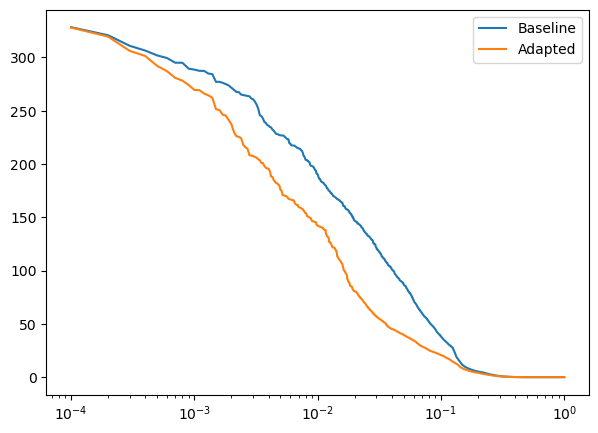

In [16]:
# E-P plot
sector = "CAP_dam"
baseline_losses_sorted = np.sort(baseline_losses_df[sector])[::-1] / 1e9
adapted_losses_sorted = np.sort(adapted_losses_df[sector])[::-1] / 1e9
N = len(baseline_losses_df[sector])
exceedance_prob = np.arange(1, N+1) / (N + 1)
plt.figure(figsize=(7,5))
plt.plot(exceedance_prob, baseline_losses_sorted, label='Baseline')
plt.plot(exceedance_prob, adapted_losses_sorted, label='Adapted')
plt.legend()
plt.xscale("log")   # optional but standard in catastrophe modelling
plt.yscale("linear")


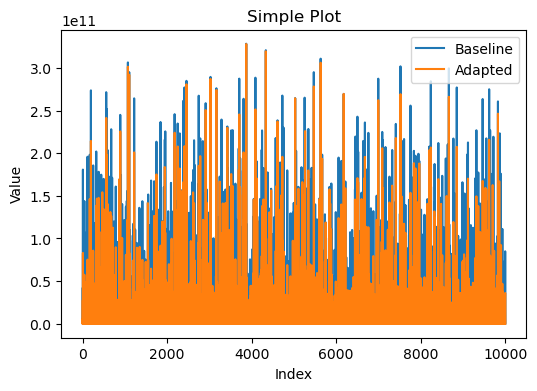

In [17]:
# Simple Simulation Series Plot
plt.figure(figsize=(6,4))
plt.plot(baseline_losses_df['CAP_dam'], label='Baseline')
plt.plot(adapted_losses_df['CAP_dam'], label='Adapted')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Simple Plot")
plt.show()

### Scratch

In [41]:
# Independent simulation
rng = np.random.default_rng(seed=42)  # for reproducibility
# Run a simulation with independence between basins
for t in tqdm(range(n_years)):
    sector_year_baseline = {s: 0.0 for s in all_sectors}
    sector_year_adapted = {s: 0.0 for s in all_sectors}

    for basin_id in basin_ids:
        curve = basin_curves[basin_id]

        # draw an independent U(0,1) for this basin-year
        u = rng.random()
        aep_event = 1.0 - u   # or aep_event = u, depending on how your curve is defined

        for s in all_sectors:
            bl = curve.loss_at_event_aep(aep_event, sector=s)
            ad = curve.loss_at_event_aep(
                aep_event,
                scenario="adaptation",
                adapted_protection_aep=adaptation_aep,
                sector=s,
            )
            sector_year_baseline[s] += bl
            sector_year_adapted[s] += ad

    for s in all_sectors:
        sector_baseline_losses[s][t] = sector_year_baseline[s]
        sector_adapted_losses[s][t] = sector_year_adapted[s]

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [04:20<00:00, 192.28it/s]


In [42]:
# Store Results
# GVA losses (sum of GVA sectors)
gva_baseline_losses = sum(sector_baseline_losses[s] for s in gva_sectors)
gva_adapted_losses  = sum(sector_adapted_losses[s]  for s in gva_sectors)

# Capital stock losses (sum of capital sectors)
cap_baseline_losses = sum(sector_baseline_losses[s] for s in cap_sectors)
cap_adapted_losses  = sum(sector_adapted_losses[s]  for s in cap_sectors)

# Store in dataframe
baseline_losses_df = pd.DataFrame({
    "year_index": np.arange(n_years),
    "GVA_loss": gva_baseline_losses,
    "CAP_dam": cap_baseline_losses,
    "AGR_loss": sector_baseline_losses["Agriculture"],
    "MAN_loss": sector_baseline_losses["Manufacturing"],
    "SER_loss": sector_baseline_losses["Service"],
    "PUB_dam": sector_baseline_losses["Public"],
    "PRI_dam": sector_baseline_losses["Private"]
})

# Store in dataframe
adapted_losses_df = pd.DataFrame({
    "year_index": np.arange(n_years),
    "GVA_loss": gva_adapted_losses,
    "CAP_dam": cap_adapted_losses,
    "AGR_loss": sector_adapted_losses["Agriculture"],
    "MAN_loss": sector_adapted_losses["Manufacturing"],
    "SER_loss": sector_adapted_losses["Service"],
    "PUB_dam": sector_adapted_losses["Public"],
    "PRI_dam": sector_adapted_losses["Private"]
})

print("GVA AAL baseline:", gva_baseline_losses.mean())
print("GVA AAL adapted :", gva_adapted_losses.mean())
print("Cap AAL baseline:", cap_baseline_losses.mean())
print("Cap AAL adapted :", cap_adapted_losses.mean())

print("GVA AAL avoided :", gva_baseline_losses.mean() - gva_adapted_losses.mean())
print("Cap AAL avoided :", cap_baseline_losses.mean() - cap_adapted_losses.mean())

GVA AAL baseline: 4251404599.4592586
GVA AAL adapted : 2474283409.2611217
Cap AAL baseline: 12539787504.079584
Cap AAL adapted : 7568790472.048731
GVA AAL avoided : 1777121190.1981368
Cap AAL avoided : 4970997032.030853


In [50]:
# Pull sector quantile loss
sector = "CAP_dam"
quantile = 0.9998
baseline_loss = baseline_losses_df[sector].quantile(quantile)
adapted_loss = adapted_losses_df[sector].quantile(quantile)
print(f'Baseline p:{quantile} loss: {baseline_loss}')
print(f'Adapted p:{quantile} loss: {adapted_loss}')

Baseline p:0.9998 loss: 122160496365.34007
Adapted p:0.9998 loss: 113086728272.2765


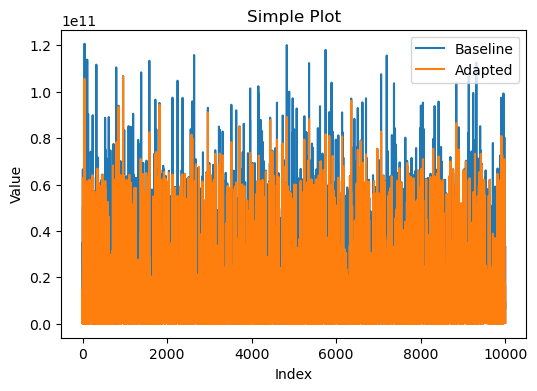

In [13]:
# Simple Simulation Series Plot
plt.figure(figsize=(6,4))
plt.plot(baseline_losses_df['CAP_dam'], label='Baseline')
plt.plot(adapted_losses_df['CAP_dam'], label='Adapted')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Simple Plot")
plt.show()

#### Plot EVENTS (copula check)

In [21]:
## Functions and colourcoding for plots
# Return period bins (inclusive of lower bound)
rp_bins = [0, 2, 5, 10, 20, 50, 100, 200, 500, 10_000]  # last one catches >500

# Colours:
# First: grey for 0–2
# Then: 8 steps of viridis
viridis = plt.cm.viridis(np.linspace(0.2, 1, len(rp_bins) - 2))
colors = ["lightgrey"] + list(viridis)

rp_cmap = ListedColormap(colors)
rp_norm = BoundaryNorm(rp_bins, rp_cmap.N)

def plot_rp_classes(sim_year, aep_df, basins_gdf,
                    basin_id_field="HYBAS_ID_str",
                   reverse=False):
    """
    Discrete return-period class map for a given simulation year.
    """

    # ---- Select AEP row ----
    if isinstance(sim_year, int):
        row = aep_df.iloc[sim_year]
        label = f"simulation year {sim_year}"
    else:
        row = aep_df.loc[sim_year]
        label = f"year {sim_year}"

    # ---- Format AEP as a long table ----
    df = row.rename("aep").reset_index()
    df.columns = [basin_id_field, "aep"]

    if reverse == True:
        df['aep'] = 1 - df['aep']

    # ---- Join onto basins ----
    gdf = basins_gdf.merge(df, on=basin_id_field, how="left")

    # Compute return period safely
    gdf["rp"] = np.where(gdf["aep"] > 0, 1.0 / gdf["aep"], np.nan)

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(8, 8))

    gdf.plot(
        column="rp",
        cmap=rp_cmap,
        norm=rp_norm,
        legend=True,
        edgecolor="black",
        linewidth=0.1,
        ax=ax,
    )

    ax.set_title(f"Basin Return Period – {label}")
    ax.set_axis_off()
    plt.tight_layout()

    return fig, ax


In [22]:
# Load data
l6_basins_path = os.path.join(root, 'inputs', 'boundaries', 'basins', 'BA_THA_lev06.shp')
# Copula random numbers
aep_df = c_random_numbers.copy()
aep_df.columns = aep_df.columns.astype(str)
basin_cols = aep_df.columns
# Independent random #s
indep_df = pd.DataFrame(np.random.rand(1000, len(basin_cols)), columns=basin_cols)
l6_basins = gpd.read_file(l6_basins_path)
l6_basins['HYBAS_ID_str'] = l6_basins['HYBAS_ID'].astype(str)

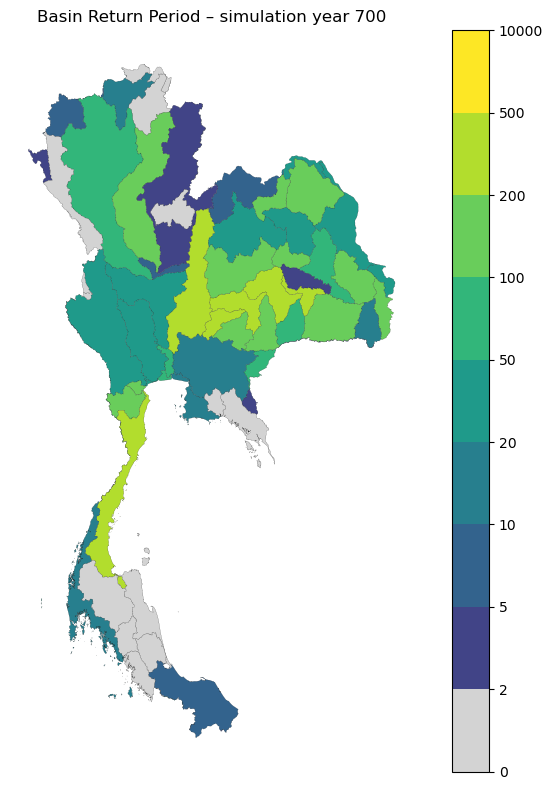

In [44]:
sim_n = 700
fig, ax = plot_rp_classes(sim_n, aep_df, l6_basins, reverse=True)